In [44]:
!pip install pytorch-tabnet -q

In [45]:
import numpy as np
import pandas as pd
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings('ignore')



In [46]:


X_train = pd.read_csv('Dataset/X_train_100.csv')
y_train = pd.read_csv('Dataset/y_train_100.csv').iloc[:, 0]
X_test = pd.read_csv('Dataset/X_test.csv')
y_test = pd.read_csv('Dataset/y_test.csv').iloc[:, 0]

print(f" Data loaded successfully!")
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")

✅ Data loaded successfully!
Training set: 235700 samples, 20 features
Test set: 37792 samples, 20 features


In [47]:
print(" Data Information:")
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

print(f"\nNumber of classes: {len(np.unique(y_train))}")
print(f"Classes: {sorted(np.unique(y_train))}")

print("\nClass distribution in training data:")
print(y_train.value_counts().sort_index())

 Data Information:
Training features shape: (235700, 20)
Training labels shape: (235700,)
Test features shape: (37792, 20)
Test labels shape: (37792,)

Number of classes: 5
Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Class distribution in training data:
0
0    47140
1    47140
2    47140
3    47140
4    47140
Name: count, dtype: int64


In [48]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int64)
y_test_np = y_test.values.astype(np.int64)

print(" Data converted to TabNet format")
print(f"X_train shape: {X_train_np.shape}")
print(f"X_test shape: {X_test_np.shape}")
print(f"y_train shape: {y_train_np.shape}")
print(f"y_test shape: {y_test_np.shape}")

 Data converted to TabNet format
X_train shape: (235700, 20)
X_test shape: (37792, 20)
y_train shape: (235700,)
y_test shape: (37792,)


In [49]:
n_features = X_train_np.shape[1]
n_classes = len(np.unique(y_train_np))

print(f" TabNet dimensions:")
print(f"Input features: {n_features}")
print(f"Output classes: {n_classes}")
print(f"Training samples: {X_train_np.shape[0]:,}")
print(f"Test samples: {X_test_np.shape[0]:,}")

 TabNet dimensions:
Input features: 20
Output classes: 5
Training samples: 235,700
Test samples: 37,792


In [50]:
tabnet_model = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    n_independent=2,
    n_shared=2,
    seed=42,
    verbose=1
)

---

## Display TabNet Info

In [51]:
print(" TabNet Architecture Details:")
print(f"Model type: {type(tabnet_model).__name__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"Optimizer: Adam")
print(f"Regularization: L1 sparse (λ={1e-3})")

 TabNet Architecture Details:
Model type: TabNetClassifier
Device: GPU
Optimizer: Adam
Regularization: L1 sparse (λ=0.001)


In [52]:
train_start_time = time.time()

---

## Train TabNet Model

In [53]:
tabnet_model.fit(
    X_train=X_train_np,
    y_train=y_train_np,
    eval_set=[
      (X_train_np, y_train_np),
      (X_test_np,  y_test_np)
    ],
    eval_name=['train', 'test'],
    eval_metric=['accuracy','logloss'],
    max_epochs=100,
    patience=15,
    batch_size=1024,
    virtual_batch_size=512,
    num_workers=0,
    drop_last=False
)


epoch 0  | loss: 0.10813 | train_accuracy: 0.92772 | train_logloss: 0.27269 | test_accuracy: 0.94314 | test_logloss: 0.2022  |  0:00:24s
epoch 1  | loss: 0.03975 | train_accuracy: 0.98941 | train_logloss: 0.03394 | test_accuracy: 0.9819  | test_logloss: 0.06098 |  0:00:40s
epoch 2  | loss: 0.03443 | train_accuracy: 0.97822 | train_logloss: 0.07426 | test_accuracy: 0.98661 | test_logloss: 0.06808 |  0:00:57s
epoch 3  | loss: 0.02919 | train_accuracy: 0.9887  | train_logloss: 0.03346 | test_accuracy: 0.98288 | test_logloss: 0.05549 |  0:01:13s
epoch 4  | loss: 0.02195 | train_accuracy: 0.95798 | train_logloss: 0.14403 | test_accuracy: 0.98775 | test_logloss: 0.04212 |  0:01:30s
epoch 5  | loss: 0.01997 | train_accuracy: 0.86647 | train_logloss: 0.85163 | test_accuracy: 0.98873 | test_logloss: 0.05541 |  0:01:46s
epoch 6  | loss: 0.03421 | train_accuracy: 0.99337 | train_logloss: 0.02209 | test_accuracy: 0.98661 | test_logloss: 0.04596 |  0:02:02s
epoch 7  | loss: 0.01921 | train_accuracy

---

## Calculate Training Time

In [54]:
train_end_time = time.time()
training_time = train_end_time - train_start_time

print(f"\n Training completed in {training_time:.2f} seconds")


 Training completed in 408.80 seconds


In [55]:
print(" Calculating training accuracy...")
train_pred_start = time.time()

y_train_pred = tabnet_model.predict(X_train_np)

train_pred_end = time.time()
train_pred_time = train_pred_end - train_pred_start

training_accuracy = accuracy_score(y_train_np, y_train_pred)

print(f" Training prediction completed in {train_pred_time:.2f} seconds")
print(f" Training Accuracy: {training_accuracy:.4f} ({training_accuracy*100:.2f}%)")

 Calculating training accuracy...
 Training prediction completed in 4.74 seconds
 Training Accuracy: 0.9972 (99.72%)


---

## Make Test Predictions

In [56]:
print(" Making predictions on test set...")
test_start_time = time.time()

y_pred = tabnet_model.predict(X_test_np)

test_end_time = time.time()
testing_time = test_end_time - test_start_time

print(f" Testing completed in {testing_time:.2f} seconds")

 Making predictions on test set...
 Testing completed in 0.75 seconds


---

## Calculate Test Accuracy

In [57]:
test_accuracy = accuracy_score(y_test_np, y_pred)

print(f" TabNet Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

 TabNet Test Accuracy: 0.9942 (99.42%)


---

## Detailed Performance Metrics

In [58]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test_np, y_pred, average='weighted')
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_np, y_train_pred, average='weighted')

print(" DETAILED TABNET PERFORMANCE:")
print("="*40)
print("TRAINING SET:")
print(f"Accuracy:  {training_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")
print()
print("TEST SET:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print()
print("TIMING:")
print(f"Training time: {training_time:.2f} seconds")
print(f"Testing time: {testing_time:.2f} seconds")
print("="*40)

 DETAILED TABNET PERFORMANCE:
TRAINING SET:
Accuracy:  0.9972
Precision: 0.9972
Recall:    0.9972
F1-Score:  0.9972

TEST SET:
Accuracy:  0.9942
Precision: 0.9960
Recall:    0.9942
F1-Score:  0.9949

TIMING:
Training time: 408.80 seconds
Testing time: 0.75 seconds


In [59]:
print(" Detailed Classification Report:")
print(classification_report(y_test_np, y_pred))

 Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13778
           1       0.99      1.00      0.99      3497
           2       0.79      0.96      0.87       298
           3       0.20      1.00      0.33        16
           4       1.00      0.99      0.99     20203

    accuracy                           0.99     37792
   macro avg       0.79      0.99      0.84     37792
weighted avg       1.00      0.99      0.99     37792



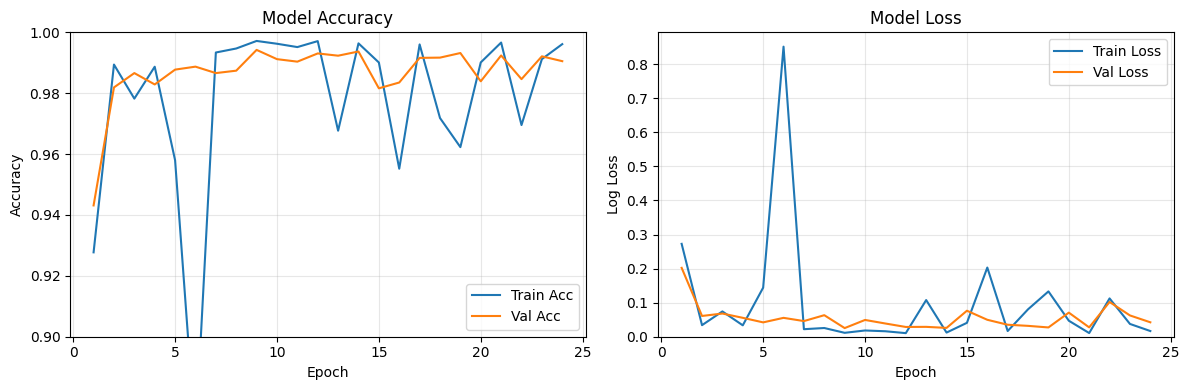

In [62]:
import matplotlib.pyplot as plt

# grab the history dict
hist   = tabnet_model.history.history
epochs = range(1, len(hist['train_accuracy']) + 1)

plt.figure(figsize=(12, 4))

# ── Accuracy ──────────────────────────────────────────────
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['train_accuracy'], label='Train Acc')
plt.plot(epochs, hist['test_accuracy'],  label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(); plt.grid(alpha=0.3)

# ── Loss ──────────────────────────────────────────────────
plt.subplot(1, 2, 2)
plt.plot(epochs, hist['train_logloss'], label='Train Loss')
plt.plot(epochs, hist['test_logloss'],  label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Log Loss')
plt.ylim(bottom=0)
plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


---

## Final TabNet Summary

In [61]:
print("📋 TABNET NEURAL NETWORK FINAL SUMMARY:")
print("="*55)
print(f"Architecture: Google's TabNet for tabular data")
print(f"Decision width: 32, Attention width: 32, Steps: 5")
print(f"Training time: {training_time:.2f}s")
print(f"Training accuracy: {training_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Accuracy gap: {(training_accuracy-test_accuracy)*100:.2f}%")

📋 TABNET NEURAL NETWORK FINAL SUMMARY:
Architecture: Google's TabNet for tabular data
Decision width: 32, Attention width: 32, Steps: 5
Training time: 408.80s
Training accuracy: 0.9972
Test accuracy: 0.9942
Accuracy gap: 0.29%
